In [121]:
import hashlib
import os
import tarfile
import zipfile
import requests

#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [122]:
def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [123]:
def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

In [124]:
# 如果你没有安装pandas，请取消下一行的注释
# !pip install pandas

%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [125]:
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

他首先还是从csv文件中读取数据，然后再说后面的处理步骤

In [126]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [127]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


数据预处理：对id值进行清除，并且将为空的值设置为相应特征的平均值，通过将特征重新缩放到零均值和单位方差来标准化数据

all_features.dtypes #数据只有几种类型 数值型和object类型
all_features.dtypes != 'object' # 每列返回真假
all_features.dtypes[all_features.dtypes != 'object'] # 按照条件进行筛选，为真保留，为假删除
all_features.dtypes[all_features.dtypes != 'object'].index # 返回一个可迭代的名字index

In [152]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:])) #对于train_data去除第一列和最后一列，对于testdata只需要去除第一列（因为index并不是我数据的特征，不能影响我最后的测试结果）
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
# all_features[numeric_features]
all_features[numeric_features] = all_features[numeric_features].apply( lambda x:(x-x.mean())/(x.std()))
all_features[numeric_features] = all_features[numeric_features].fillna(0)
all_features

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,0.067320,RL,-0.184443,-0.217841,Pave,NaN,Reg,Lvl,AllPub,Inside,...,-0.063139,NaN,NaN,NaN,-0.089577,-1.551918,0.157619,WD,Normal,0.000000
1,-0.873466,RL,0.458096,-0.072032,Pave,NaN,Reg,Lvl,AllPub,FR2,...,-0.063139,NaN,NaN,NaN,-0.089577,-0.446848,-0.602858,WD,Normal,0.000000
2,0.067320,RL,-0.055935,0.137173,Pave,NaN,IR1,Lvl,AllPub,Inside,...,-0.063139,NaN,NaN,NaN,-0.089577,1.026577,0.157619,WD,Normal,0.000000
3,0.302516,RL,-0.398622,-0.078371,Pave,NaN,IR1,Lvl,AllPub,Corner,...,-0.063139,NaN,NaN,NaN,-0.089577,-1.551918,-1.363335,WD,Abnorml,0.000000
4,0.067320,RL,0.629439,0.518814,Pave,NaN,IR1,Lvl,AllPub,FR2,...,-0.063139,NaN,NaN,NaN,-0.089577,2.131647,0.157619,WD,Normal,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2.419286,RM,-2.069222,-1.043758,Pave,NaN,Reg,Lvl,AllPub,Inside,...,-0.063139,NaN,NaN,NaN,-0.089577,-0.078492,-1.363335,WD,Normal,-1.362066
1455,2.419286,RM,-2.069222,-1.049083,Pave,NaN,Reg,Lvl,AllPub,Inside,...,-0.063139,NaN,NaN,NaN,-0.089577,-0.815205,-1.363335,WD,Abnorml,-1.391135
1456,-0.873466,RL,3.884968,1.246594,Pave,NaN,Reg,Lvl,AllPub,Inside,...,-0.063139,NaN,NaN,NaN,-0.089577,1.026577,-1.363335,WD,Abnorml,-0.092760
1457,0.655311,RL,-0.312950,0.034599,Pave,NaN,Reg,Lvl,AllPub,Inside,...,-0.063139,NaN,MnPrv,Shed,1.144116,0.289865,-1.363335,WD,Normal,-0.931697


对于离散值(字符串)，我们用一次独热编码替换他们，如果一个列有5个值，那么就创建5个feature，所以下面的数据特征就变大了

In [130]:
all_features = pd.get_dummies(all_features,dummy_na=True)# 如果是missData也要进行处理，特别的特征
all_features.shape

(2919, 331)

将pandas的格式数据变成Numpy
想一想，为什么需要reshape呢？因为如果不reshape，那么返回回来是list
train_data.SalePrice.values.shape （1460，）
但是如果reshape一下
    train_data.SalePrice.values.reshape(-1,1).shape （1460，1）
再转换成Torch的时候，就是1460列（表示数据量，批次）后面的就是数值

In [131]:
n_train = train_data.shape[0]# 获取数据的个数
# 训练数据进行获取
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_data.SalePrice.values
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)



设置训练参数

In [132]:
loss = nn.MSELoss()
in_features = train_features.shape[1] # shape【】 用来
def get_net():
    net = nn.Sequential(nn.Linear(in_features, 1))
    return net

torch.clamp(input, min, max, out=None)  将输入input张量每个元素的范围限制到区间 [min,max]，返回结果到一个新张量。
之前我们使用的是真实值- 误差值的平方作为损失函数，但是这个对于房价而言，并不是很好用（如果使用绝对的均方误差，那么100W的房子的误差的权重一定会大一点，小房子的误差就会小一点）——比较大的，正值一般就是使用log
我们更加关心相对误差(y-y_hat)/y 解决这个问题的一种方式使用价格预测的对数来衡量差异
Use torch.Tensor.item() to get a Python number from a tensor containing a single value.

In [133]:
def log_rmse(net,features,labels):
    clipped_pred = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_pred), torch.log(labels)))
    return rmse.item()

训练函数，这里引入了特别的Adam

In [134]:
def train(net,train_features,train_labels,test_features,test_labels,mun_epoches,learning_rate,weight_decay,batch_size):
    train_ls,test_ls = [],[]
    train_iter = d2l.load_array((train_features,train_labels),batch_size)
    optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate,weight_decay= weight_decay)#Adam更加平滑的SGD，对学习率没那么敏感
    for epoch in range(mun_epoches):
        for X,y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X),y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net,test_features,test_labels))
    return train_ls,test_ls

K折交叉验证

In [135]:
def get_k_fold_data(k,i,X,y):
    assert k>1
    fold_size = X.shape[0]//k  # //的意思就是除号 这里算出来是每折的大小
    X_train,y_train = None,None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size) # 这里算出来就是每折的索引号
        X_part,y_part = X[idx, :], y[idx]
        if j ==i:# 如果他是设定的目标，就设置为他是valid数据集
            X_valid,y_valid = X_part,y_part
        elif X_train is None:
            X_train,y_train = X_part,y_part
        else:
            X_train = torch.cat([X_train,X_part],0)
            y_train = torch.cat([y_train,y_part],0)
    return X_train,y_train,X_valid,y_valid

返回训练和验证误差的平均值

In [136]:
def k_fold(k,X_train,y_train,num_epochs,learning_rate,weght_decay,batch_size):
    train_l_sum,valid_l_sum = 0,0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls,valid_ls = train(net, *data, num_epochs, learning_rate, weght_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

折1，训练log rmse0.364104, 验证log rmse0.176359
折2，训练log rmse0.192746, 验证log rmse0.646188
折3，训练log rmse0.355176, 验证log rmse0.215857
折4，训练log rmse0.362157, 验证log rmse0.163975
折5，训练log rmse0.359794, 验证log rmse0.200455
5-折验证: 平均训练log rmse: 0.326795, 平均验证log rmse: 0.280567


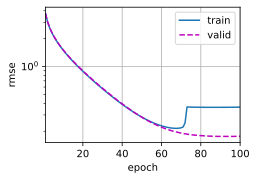

In [137]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

In [138]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

训练log rmse：0.134021


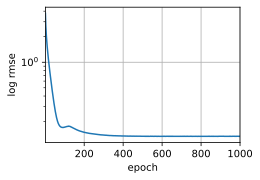

In [151]:
k, num_epochs, lr, weight_decay, batch_size = 4, 1000, 4, 0.1, 64
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)